# Import

In [82]:
pip install -U albumentations

Note: you may need to restart the kernel to use updated packages.


In [83]:
import albumentations as A
import os
from datetime import datetime
import numpy as np
import pandas as pd
import keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import RandomTranslation
import matplotlib.pyplot as plt
%matplotlib inline

seed = 45
np.random.seed(seed)
tf.random.set_seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")
BATCH_SIZE = 64

TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


In [84]:
ALBUMENTATION = True

# Load Data

In [85]:
training_data = np.load("/kaggle/input/cleaneddataset/mars_for_students_cleaned_compressed.npz")
images = training_data["images"].astype(np.uint8)
labels = training_data["labels"].astype(np.uint8)

# Split Data

In [86]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2)

# Albumentations

In [87]:
# Definire la probabilità globale
prob = 0.4

# Definizione delle trasformazioni con p=prob
transforms = [
    A.AdditiveNoise(
        noise_type="gaussian",
        spatial_mode="per_pixel",
        noise_params={"mean_range": [0, 0], "std_range": [0.00, 0.02]},
        p=prob
    ),
    A.CLAHE(clip_limit=(1, 4), tile_grid_size=(8, 8), p=prob),
    A.ColorJitter(
        brightness=[1.5, 2.5], contrast=[1.5, 2.5],
        saturation=[1.5, 2.5], hue=[-0.5, 0.5], p=prob
    ),
    A.InvertImg(p=prob),
    A.RandomShadow(p=prob),
    A.Affine(
        scale=[0.5, 1.5],
        translate_percent=[-0.3, 0.3],
        rotate=[-180, 180],
        shear=[-25, 25],
        p=prob
    ),
    A.GridDistortion(num_steps=5, distort_limit=[-0.6, 0.6], p=prob),
    A.HorizontalFlip(p=prob),
    A.VerticalFlip(p=prob),
    A.RandomGridShuffle(grid=(3, 3), p=prob),
    A.CoarseDropout(
        num_holes_range=(1, 2), hole_height_range=(0.1, 0.5),
        hole_width_range=(0.1, 0.5), fill=0, fill_mask=0, p=prob
    )
]

transform = A.RandomOrder(transforms, n=3, replace=False, p=1)

In [88]:
if ALBUMENTATION:
    
    N, H, W = X_train.shape  # Ottieni la dimensione delle immagini originali
    
    # Applica la trasformazione in batch
    for i in range(N):
        transformed = transform(image=X_train[i], mask=y_train[i])  # Trasformazione singola
        X_train[i] = transformed['image']  # Salva l'immagine trasformata
        y_train[i] = transformed['mask']    # Salva la maschera trasformata

# Custom augmentation

In [89]:
"add_channel"
def add_channel(image, label):
    image = tf.cast(image, tf.float32)
    label = tf.cast(label, tf.float32)
    image = tf.expand_dims(image, axis=-1)
    label = tf.expand_dims(label, axis=-1)
    return image, label

def add_channel_lambda(dataset):
    return dataset.map(
                        lambda x, y: add_channel(x, y),
                        num_parallel_calls=tf.data.AUTOTUNE
                       )

In [90]:
"Flip Left Right"
@tf.function
def random_flip_left_right(image, label, thr):
    prob = tf.random.uniform([])

    image, label = tf.cond(
        prob < thr,
        lambda: (tf.image.flip_left_right(image), tf.image.flip_left_right(label)),
        lambda: (image, label)
    )

    return image, label

def random_flip_left_right_lambda(dataset, thr):
    return dataset.map(
                        lambda x, y: random_flip_left_right(x, y, thr),
                        num_parallel_calls=tf.data.AUTOTUNE
                       )

In [91]:
"Flip Up Down"
@tf.function
def random_flip_up_down(image, label, thr):
    prob = tf.random.uniform([])

    image, label = tf.cond(
        prob < thr,
        lambda: (tf.image.flip_up_down(image), tf.image.flip_up_down(label)),
        lambda: (image, label)
    )

    return image, label

def random_flip_up_down_lambda(dataset, thr):
    return dataset.map(
                        lambda x, y: random_flip_up_down(x, y, thr),
                        num_parallel_calls=tf.data.AUTOTUNE
                       )

In [92]:
"Translation"
@tf.function
def translation(image, label):
    max_translation = 0.5

    # Dimensioni dell'immagine
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]

    # Calcolo massimo spostamento in base alla percentuale specificata
    max_dx = tf.cast(max_translation * tf.cast(width, tf.float32), tf.int32)
    max_dy = tf.cast(max_translation * tf.cast(height, tf.float32), tf.int32)

    # Generazione spostamenti casuali
    dx = tf.random.uniform([], -max_dx, max_dx + 1, dtype=tf.int32)
    dy = tf.random.uniform([], -max_dy, max_dy + 1, dtype=tf.int32)

    # Funzione per lo shift con riempimento a zero
    def zero_fill_translation():
        white_image = tf.ones((64, 128, 1), dtype=tf.float32)
        padded_image = tf.image.pad_to_bounding_box(white_image, max_dy, max_dx, height + 2 * max_dy, width + 2 * max_dx)
        cropped_image = tf.image.crop_to_bounding_box(padded_image, max_dy - dy, max_dx - dx, height, width)
        padded_label = tf.image.pad_to_bounding_box(white_image, max_dy, max_dx, height + 2 * max_dy, width + 2 * max_dx)
        cropped_label = tf.image.crop_to_bounding_box(padded_label, max_dy - dy, max_dx - dx, height, width)
        return image*cropped_image, label*cropped_label

    # Funzione per lo shift con riflessione
    def reflection_translation():
        translated_image = tf.roll(image, shift=[dy, dx], axis=[0, 1])
        translated_label = tf.roll(label, shift=[dy, dx], axis=[0, 1])
        return translated_image, translated_label

    # Decide casualmente tra riflessione o riempimento di zeri
    use_reflection = tf.random.uniform([], 0, 1) < 0.8
    translated_image, translated_label = tf.cond(
        use_reflection,
        true_fn=reflection_translation,
        false_fn=zero_fill_translation
    )

    return translated_image, translated_label


@tf.function
def random_translation(image, label, thr):
    prob = tf.random.uniform([])

    image, label = tf.cond(
        prob < thr,
        lambda: (translation(image, label)),
        lambda: (image, label)
    )
    return image, label

def translation_lambda(dataset, thr):
    return dataset.map(
                        lambda x, y: random_translation(x, y, thr),
                        num_parallel_calls=tf.data.AUTOTUNE
                       )

In [93]:
"zoom"
@tf.function
def zoom(image, label, zoom_range=(0.8, 1.2)):
    # Genera un fattore di zoom casuale
    zoom_factor = tf.random.uniform([], zoom_range[0], zoom_range[1])

    # Ottieni le dimensioni originali
    original_height = tf.shape(image)[0]
    original_width = tf.shape(image)[1]

    # Calcola le nuove dimensioni dopo lo zoom
    new_height = tf.cast(tf.cast(original_height, tf.float32) * zoom_factor, tf.int32)
    new_width = tf.cast(tf.cast(original_width, tf.float32) * zoom_factor, tf.int32)

    # Ridimensiona l'immagine e la maschera
    zoomed_image = tf.image.resize(image, [new_height, new_width], method='bilinear')
    zoomed_label = tf.image.resize(label, [new_height, new_width], method='bilinear')  # Per maschere, meglio 'nearest'

    # Ritaglia o pad per riportare alle dimensioni originali
    cropped_image = tf.image.resize_with_crop_or_pad(zoomed_image, original_height, original_width)
    cropped_label = tf.image.resize_with_crop_or_pad(zoomed_label, original_height, original_width)

    return cropped_image, cropped_label

@tf.function
def random_zoom(image, label, thr):
    prob = tf.random.uniform([])

    image, label = tf.cond(
        prob < thr,
        lambda: (zoom(image, label)),
        lambda: (image, label)
    )
    return image, label

def zoom_lambda(dataset, thr):
    return dataset.map(
        lambda x, y: random_zoom(x, y, thr),
        num_parallel_calls=tf.data.AUTOTUNE
    )


In [94]:
"Cutout"
@tf.function
def cutout(image, label):
    # Calcola altezza e larghezza dell'immagine
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]


    # Genera la dimensione del quadrato
    square_size = tf.random.uniform([], 15, 48 + 1, dtype=tf.int32)

    # Genera la posizione del quadrato
    max_x = tf.maximum(0, width - square_size)
    max_y = tf.maximum(0, height - square_size)

    start_x = tf.random.uniform([], 0, max_x + 1, dtype=tf.int32)
    start_y = tf.random.uniform([], 0, max_y + 1, dtype=tf.int32)

    # Crea una maschera per "cancellare" il quadrato
    mask = tf.ones_like(image)
    mask = tf.tensor_scatter_nd_update(
        mask,
        indices=tf.stack(tf.meshgrid(
            tf.range(start_y, start_y + square_size),
            tf.range(start_x, start_x + square_size)
        ), axis=-1),
        updates=tf.zeros([square_size, square_size, tf.shape(image)[-1]], dtype=image.dtype)
    )

    # Applica la maschera a immagine e label
    zeroed_image = image * mask
    zeroed_label = label * mask

    return zeroed_image, zeroed_label

@tf.function
def random_cutout(image, label, thr):
    prob = tf.random.uniform([])

    image, label = tf.cond(
        prob < thr,
        lambda: cutout(image,label),
        lambda: (image, label)
    )
    return image, label

def cutout_lambda(dataset, thr):
    return dataset.map(
        lambda x, y: random_cutout(x, y, thr),
        num_parallel_calls=tf.data.AUTOTUNE
    )



In [95]:
"contrast"
@tf.function
def random_contrast(image, label, thr):
    prob = tf.random.uniform([], seed=seed)
    factor = tf.random.uniform([], minval=-4, maxval=4, seed=seed)


    image, label = tf.cond(
        prob < thr,
        lambda: (tf.image.adjust_contrast(image, factor), label),
        lambda: (image, label)
    )
    return image, label

def contrast_lambda(dataset, thr):
    return dataset.map(
        lambda x, y: random_contrast(x, y, thr),
        num_parallel_calls=tf.data.AUTOTUNE
    )

In [96]:
"rotate"
@tf.function
def rotate(image, label, max_angle=30):
    """
    Ruota l'immagine e la sua maschera di un angolo casuale tra -max_angle e +max_angle gradi.

    Parametri:
    - image: Tensor, immagine di input (64, 128, 1).
    - label: Tensor, maschera associata (64, 128, 1).
    - max_angle: int, angolo massimo di rotazione (default 30 gradi).

    Ritorna:
    - image, label: immagine e maschera ruotate.
    """
    # Genera un angolo casuale tra -max_angle e +max_angle (in gradi)
    angle = tf.random.uniform([], minval=-max_angle, maxval=max_angle, dtype=tf.float32)

    # Converte l'angolo in radianti
    angle_rad = angle * tf.constant(np.pi / 180, dtype=tf.float32)  # Converte in radianti

    # Crea la matrice di trasformazione affine per la rotazione
    rotation_matrix = tf.stack([
        tf.cos(angle_rad), -tf.sin(angle_rad), 0.0,
        tf.sin(angle_rad), tf.cos(angle_rad), 0.0,
        0.0, 0.0, 1.0
    ])

    # Applica la trasformazione affine all'immagine e alla maschera
    image = tf.image.transform(image, rotation_matrix, interpolation='BILINEAR')
    label = tf.image.transform(label, rotation_matrix, interpolation='NEAREST')

    return image, label

@tf.function
def random_rotate(image, label, thr):
    prob = tf.random.uniform([])

    image, label = tf.cond(
        prob < thr,
        lambda: (rotate(image, label)),
        lambda: (image, label)
    )
    return image, label


def rotate_lambda(dataset, thr):
    """
    Applica la rotazione casuale continua a tutte le immagini e maschere di un dataset.

    Parametri:
    - dataset: tf.data.Dataset, dataset da trasformare.
    - max_angle: int, angolo massimo di rotazione (default 30 gradi).

    Ritorna:
    - Dataset con rotazione casuale applicata.
    """
    return dataset.map(
        lambda x, y: random_rotate(x, y, thr),
        num_parallel_calls=tf.data.AUTOTUNE
    )


In [97]:
"multiply"

#Replicate and concatenate the dataset multiple times, to let the augmentation work
def multiply_dataset(images, labels, quantity = 1):
        images = np.concatenate([images, images[:quantity], images[:quantity], images[:quantity]], axis=0)
        labels = np.concatenate([labels, labels[:quantity], labels[:quantity], labels[:quantity]], axis=0)
        return (images, labels)

In [98]:
"cutmix"
def paste_patch(image, label, patch_image, patch_label, patch_size=(32, 32)):
    """Incolla una porzione (patch) di un'altra immagine e label nella posizione casuale dell'immagine corrente."""
    h, w = patch_size
    img_h, img_w = image.shape[:2]

    # Definisci la posizione casuale dove incollare la patch
    top = np.random.randint(0, img_h - h, seed = seed)
    left = np.random.randint(0, img_w - w, seed = seed)

    # Incolla la patch sull'immagine
    image[top:top+h, left:left+w] = patch_image[:h, :w]
    label[top:top+h, left:left+w] = patch_label[:h, :w]

    return image, label

def data_augmentation_fn(image, label, batch_idx, patch_size=(32, 32), frequency=2):
    """Applica l'operazione di incolla una patch ogni 'frequency' batch."""
    if batch_idx % frequency == 0:
        # Seleziona una porzione casuale da un'altra immagine del dataset
        idx = np.random.randint(0, len(X_train))  # Scegli un'altra immagine casuale dal dataset
        patch_image = X_train[idx]
        patch_label = y_train[idx]

        # Incolla la patch sull'immagine e sulla label
        image, label = paste_patch(image, label, patch_image, patch_label, patch_size)

    return image, label




def cutmix_dataset(X_train, y_train):
    # Estrai indici casuali senza ripetizione
    indices = np.random.choice(len(X_train), size=len(X_train), replace=False)

    # Crea un array per le immagini e le etichette aggiornate
    X_cutmix = np.copy(X_train)
    y_cutmix = np.copy(y_train)

    # Impostiamo la dimensione della porzione da tagliare e incollare (ad esempio 50x50 pixel)
    height, width = X_train.shape[1:]  # dimensioni delle immagini
    cut_size = 50  # altezza e larghezza della porzione da incollare

    for i in range(len(X_train)):
        # Selezioniamo una porzione casuale di dimensioni cut_size x cut_size in X_random[i]
        x_offset = np.random.randint(0, width - cut_size)
        y_offset = np.random.randint(0, height - cut_size)

        # Estrai la porzione dall'immagine X_random[i]
        X_patch = X_train[indices[i], y_offset:y_offset+cut_size, x_offset:x_offset+cut_size]
        y_patch = y_train[indices[i], y_offset:y_offset+cut_size, x_offset:x_offset+cut_size]

        # Incolla la porzione nell'immagine X_train[i]
        X_cutmix[i, y_offset:y_offset+cut_size, x_offset:x_offset+cut_size] = X_patch
        y_cutmix[i, y_offset:y_offset+cut_size, x_offset:x_offset+cut_size] = y_patch
    return X_cutmix, y_cutmix

# Create Dataset

In [99]:
def to_dataset(X_train, y_train, augmentation = False, shuffle = False, batch_size = BATCH_SIZE, duplicate = False, cycles = 1):
    if duplicate:
        X_train, y_train = multiply_dataset(X_train, y_train, len(X_train))
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2)

    dataset = add_channel_lambda(dataset)

    if augmentation and not ALBUMENTATION:
        dataset = random_flip_left_right_lambda(dataset,0.4)
        dataset = random_flip_up_down_lambda(dataset,0.4)
        dataset = translation_lambda(dataset,0.4)
        #dataset = contrast_lambda(dataset,0.5)
        dataset = zoom_lambda(dataset,0.4)
        dataset = cutout_lambda(dataset,1)


    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Preview Dataset

In [100]:
train_dataset_aug = to_dataset(X_train, y_train, augmentation = True, duplicate = True, cycles = 1)
train_dataset_no_aug = to_dataset(X_train, y_train, augmentation = False, duplicate = True)

In [101]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_datasets(train_dataset_no_aug, train_dataset_aug, num_samples=5):
    """
    Funzione che stampa immagini e maschere da due dataset con 4 colonne:
    1. Immagini non augmentate
    2. Masks non augmentate
    3. Immagini augmentate
    4. Masks augmentate

    Parametri:
    - train_dataset_no_aug: Dataset TensorFlow non augmentato
    - train_dataset_aug: Dataset TensorFlow augmentato
    - num_samples: Numero di campioni da stampare
    """
    # Ottieni batch dai dataset senza consumarli
    no_aug_batch = list(train_dataset_no_aug.take(1).as_numpy_iterator())[0]
    aug_batch = list(train_dataset_aug.take(1).as_numpy_iterator())[0]

    # Divide immagini e maschere
    no_aug_images, no_aug_masks = no_aug_batch
    aug_images, aug_masks = aug_batch

    # Converte batch in array (se necessario)
    no_aug_images = no_aug_images[:num_samples]
    no_aug_masks = no_aug_masks[:num_samples]
    aug_images = aug_images[:num_samples]
    aug_masks = aug_masks[:num_samples]

    # Creazione della mappa di colori per le mask
    colors = ['black', 'blue', 'green', 'yellow', 'red']  # Colori per i valori da 0 a 4
    cmap = ListedColormap(colors)

    # Plot delle immagini
    plt.figure(figsize=(15, num_samples * 3))
    for i in range(num_samples):
        # Colonna 1: Immagini non augmentate
        plt.subplot(num_samples, 4, i * 4 + 1)
        plt.imshow(no_aug_images[i], cmap="gray")
        plt.axis("off")
        plt.title("Image (no aug)")

        # Colonna 2: Masks non augmentate
        plt.subplot(num_samples, 4, i * 4 + 2)
        plt.imshow(no_aug_masks[i], cmap=cmap, vmin=0, vmax=4)
        plt.axis("off")
        plt.title("Mask (no aug)")

        # Colonna 3: Immagini augmentate
        plt.subplot(num_samples, 4, i * 4 + 3)
        plt.imshow(aug_images[i], cmap="gray")
        plt.axis("off")
        plt.title("Image (aug)")

        # Colonna 4: Masks augmentate
        plt.subplot(num_samples, 4, i * 4 + 4)
        plt.imshow(aug_masks[i], cmap=cmap, vmin=0, vmax=4)
        plt.axis("off")
        plt.title("Mask (aug)")

    plt.tight_layout()
    plt.show()


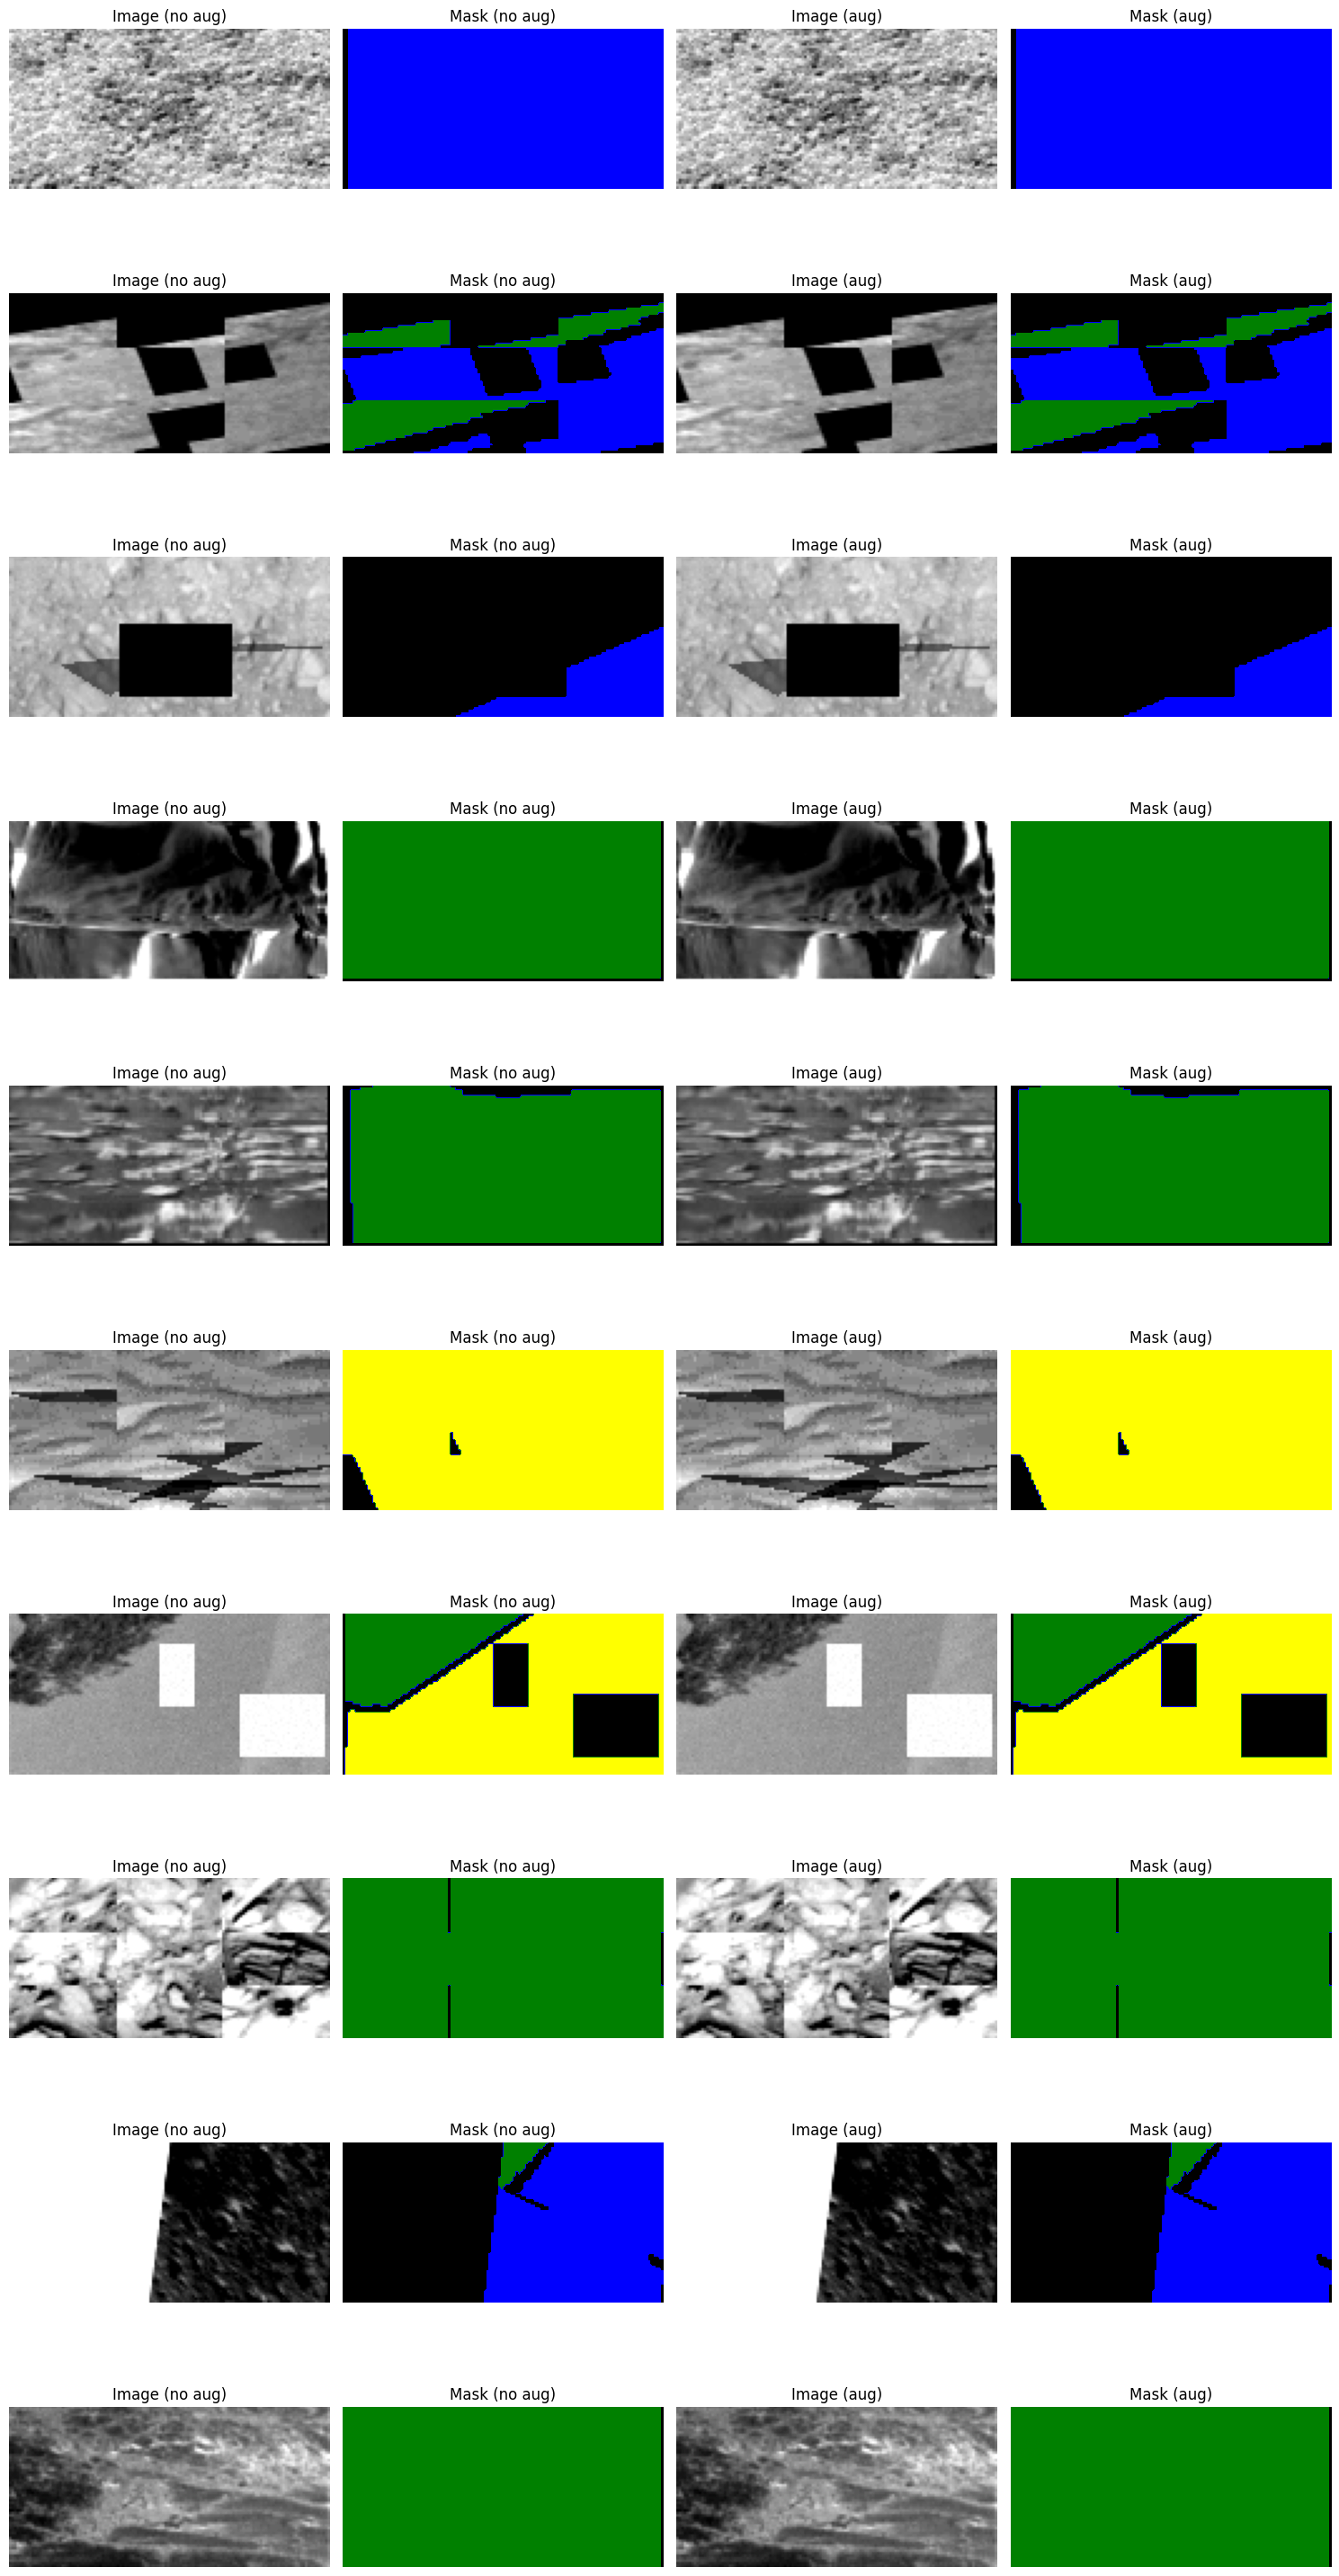

In [102]:
plot_datasets(train_dataset_no_aug, train_dataset_aug, num_samples = 10)

In [103]:
train_dataset = to_dataset(X_train, y_train, augmentation = True, duplicate = True, cycles = 2)
val_dataset = to_dataset(X_val, y_val, augmentation = False, duplicate = False)

# Model

In [104]:
num_classes = 5
epoch = 250
patience = 20

In [105]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [106]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    convol_1 = unet_block(input_layer, 32, name='down_block1')
    d1 = tfkl.MaxPooling2D()(convol_1)

    convol_2 = unet_block(d1, 64, name='down_block2')
    d2 = tfkl.MaxPooling2D()(convol_2)

    convol_3 = unet_block(d2, 128, name='down_block3')
    d3 = tfkl.MaxPooling2D()(convol_3)

    convol_4 = unet_block(d3, 256, name='down_block4')
    d4 = tfkl.MaxPooling2D()(convol_4)

    # Bottleneck
    bottleneck = unet_block(d4, 512, name='bottleneck')

    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, convol_4])
    conv_up_1 = unet_block(u1, 128, name='up_block1')


    u2 = tfkl.UpSampling2D()(conv_up_1)
    u2 = tfkl.Concatenate()([u2, convol_3])
    conv_up_2 = unet_block(u2, 128, name='up_block2')

    u3 = tfkl.UpSampling2D()(conv_up_2)
    u3 = tfkl.Concatenate()([u3, convol_2])
    conv_up_3 = unet_block(u3, 64, name='up_block3')

    u4 = tfkl.UpSampling2D()(conv_up_3)
    u4 = tfkl.Concatenate()([u4, convol_1])
    conv_up_4 = unet_block(u4, 32, name='up_block4')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(conv_up_4)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

In [107]:
model = get_unet_model()

## MIOU

In [108]:
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=[0], name="mean_iou", dtype=None, **kwargs):
        """
        Aggiunto **kwargs per gestire parametri inattesi come `ignore_class`.
        """
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        return super().update_state(y_true, y_pred, sample_weight)

# Registra la classe personalizzata
tf.keras.utils.get_custom_objects()["MeanIntersectionOverUnion"] = MeanIntersectionOverUnion

## Visualization Callback

In [109]:
from matplotlib.colors import ListedColormap

class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, dataset, frequency=5, num_classes=2):
        super().__init__()
        self.dataset = dataset
        self.frequency = frequency
        self.num_classes = num_classes
        self.dataset_iter = iter(dataset)  # Crea un iteratore per accedere ai dati

        # Crea la mappa di colori per visualizzare le maschere
        # Aggiungi qui i colori per ogni classe
        colors = ['black', 'blue', 'green', 'yellow', 'red']  # Colori per 5 classi
        self.cmap = ListedColormap(colors)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualizza solo ogni "frequency" epochs
            try:
                # Estrai un batch di dati
                image, label = next(self.dataset_iter)
            except StopIteration:
                # Ricrea l'iteratore se i dati sono terminati
                self.dataset_iter = iter(self.dataset)
                image, label = next(self.dataset_iter)

            # Prepara i dati per la predizione
            image = tf.expand_dims(image[0], 0)  # Estrai una sola immagine dal batch
            label = label[0]  # Etichetta corrispondente
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            plt.figure(figsize=(16, 4))

            # Immagine di input
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth (maschera) con la mappa di colori
            plt.subplot(1, 3, 2)
            plt.imshow(label.numpy(), cmap=self.cmap, vmin=0, vmax=self.num_classes-1)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Predizione con la mappa di colori
            plt.subplot(1, 3, 3)
            plt.imshow(y_pred[0], cmap=self.cmap, vmin=0, vmax=self.num_classes-1)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()


## Early Stopping Callback

In [110]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

viz_callback = VizCallback(val_dataset, frequency=5, num_classes=5)


## Compile

In [112]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(0.001),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=5, labels_to_exclude=[0])]
)

## Training

Epoch 1/250


W0000 00:00:1733953343.705834     130 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4413 - loss: 1.2668 - mean_iou: 0.1422

W0000 00:00:1733953360.914068     129 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.4415 - loss: 1.2661 - mean_iou: 0.1423

W0000 00:00:1733953371.811495     131 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733953377.167073     131 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


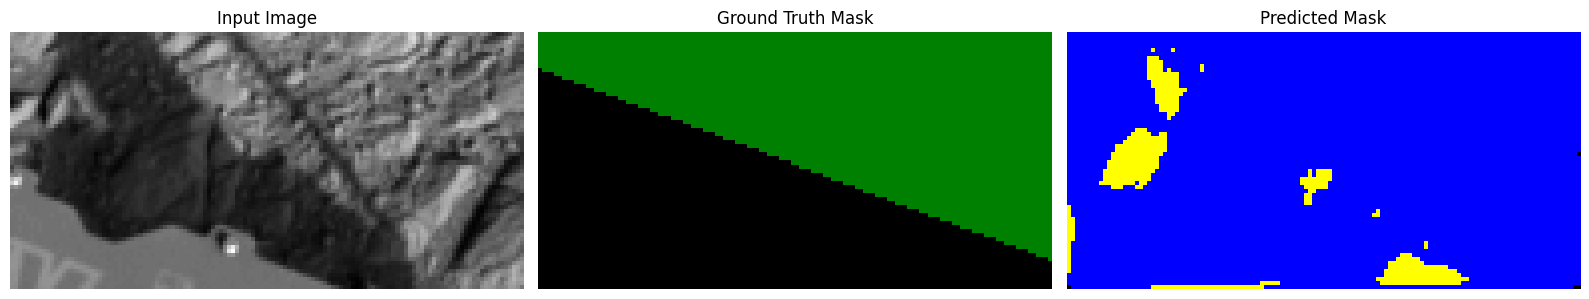

126/126 ━━━━━━━━━━━━━━━━━━━━ 52s 239ms/step - accuracy: 0.4418 - loss: 1.2654 - mean_iou: 0.1424 - val_accuracy: 0.3483 - val_loss: 1.6386 - val_mean_iou: 0.1133
Epoch 2/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.5261 - loss: 1.0774 - mean_iou: 0.1985 - val_accuracy: 0.3589 - val_loss: 1.9064 - val_mean_iou: 0.1256
Epoch 3/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.5676 - loss: 0.9958 - mean_iou: 0.2377 - val_accuracy: 0.2677 - val_loss: 3.3657 - val_mean_iou: 0.0879
Epoch 4/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.6091 - loss: 0.9275 - mean_iou: 0.2783 - val_accuracy: 0.4993 - val_loss: 1.3223 - val_mean_iou: 0.2546
Epoch 5/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.6329 - loss: 0.8794 - mean_iou: 0.3018 - val_accuracy: 0.5013 - val_loss: 1.1487 - val_mean_iou: 0.2637
Epoch 6/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6617 - loss: 0.8163 - mean_iou: 0.3278

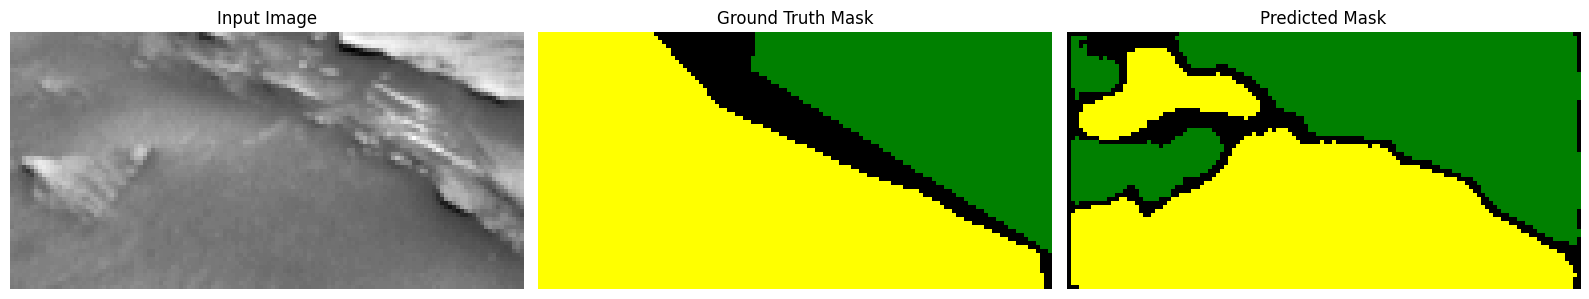

126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.6619 - loss: 0.8161 - mean_iou: 0.3279 - val_accuracy: 0.5721 - val_loss: 1.0829 - val_mean_iou: 0.3241
Epoch 7/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.6787 - loss: 0.7809 - mean_iou: 0.3465 - val_accuracy: 0.5433 - val_loss: 1.2030 - val_mean_iou: 0.2952
Epoch 8/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.7041 - loss: 0.7255 - mean_iou: 0.3683 - val_accuracy: 0.6031 - val_loss: 1.1188 - val_mean_iou: 0.3572
Epoch 9/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.7465 - loss: 0.6404 - mean_iou: 0.4061 - val_accuracy: 0.4515 - val_loss: 1.6936 - val_mean_iou: 0.1780
Epoch 10/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.7642 - loss: 0.5995 - mean_iou: 0.4201 - val_accuracy: 0.4391 - val_loss: 1.7452 - val_mean_iou: 0.1970
Epoch 11/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7981 - loss: 0.5235 - mean_iou: 0.4527

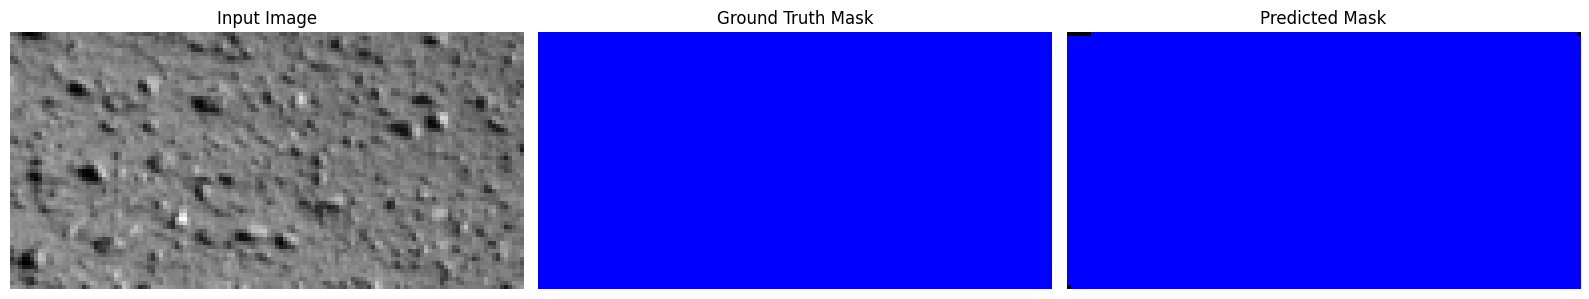

126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.7982 - loss: 0.5234 - mean_iou: 0.4527 - val_accuracy: 0.4945 - val_loss: 1.6475 - val_mean_iou: 0.2237
Epoch 12/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.8204 - loss: 0.4737 - mean_iou: 0.4678 - val_accuracy: 0.5069 - val_loss: 2.0879 - val_mean_iou: 0.2528
Epoch 13/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.8420 - loss: 0.4221 - mean_iou: 0.4874 - val_accuracy: 0.5363 - val_loss: 1.6354 - val_mean_iou: 0.2687
Epoch 14/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.8634 - loss: 0.3698 - mean_iou: 0.5049 - val_accuracy: 0.5020 - val_loss: 1.6922 - val_mean_iou: 0.2721
Epoch 15/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.8848 - loss: 0.3139 - mean_iou: 0.5228 - val_accuracy: 0.5702 - val_loss: 1.4968 - val_mean_iou: 0.3216
Epoch 16/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9002 - loss: 0.2743 - mean_iou: 0.5359

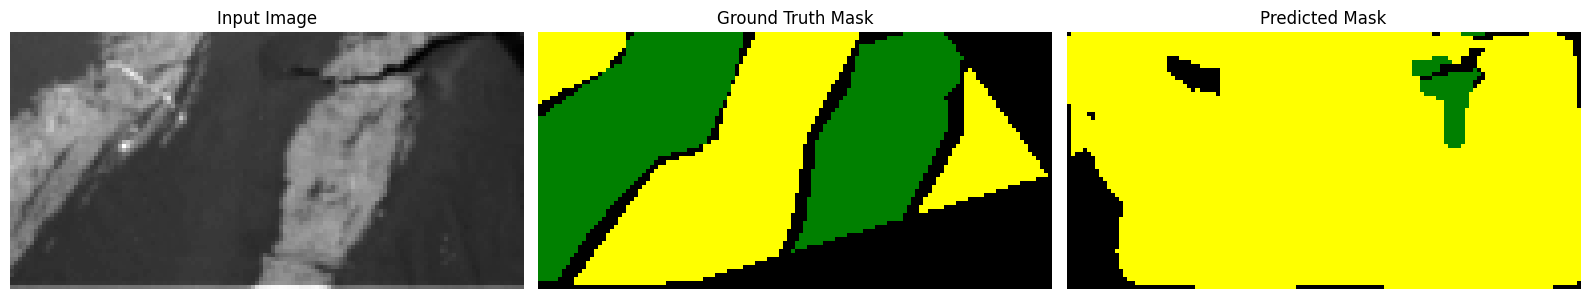

126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.9003 - loss: 0.2741 - mean_iou: 0.5359 - val_accuracy: 0.6000 - val_loss: 1.3502 - val_mean_iou: 0.3406
Epoch 17/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9105 - loss: 0.2469 - mean_iou: 0.5410 - val_accuracy: 0.5836 - val_loss: 1.3556 - val_mean_iou: 0.3314
Epoch 18/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9234 - loss: 0.2116 - mean_iou: 0.5518 - val_accuracy: 0.5545 - val_loss: 1.6276 - val_mean_iou: 0.2605
Epoch 19/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9271 - loss: 0.1991 - mean_iou: 0.5555 - val_accuracy: 0.5760 - val_loss: 1.6785 - val_mean_iou: 0.2940
Epoch 20/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9368 - loss: 0.1739 - mean_iou: 0.5625 - val_accuracy: 0.5860 - val_loss: 1.5009 - val_mean_iou: 0.3181
Epoch 21/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9404 - loss: 0.1597 - mean_iou: 0.5638

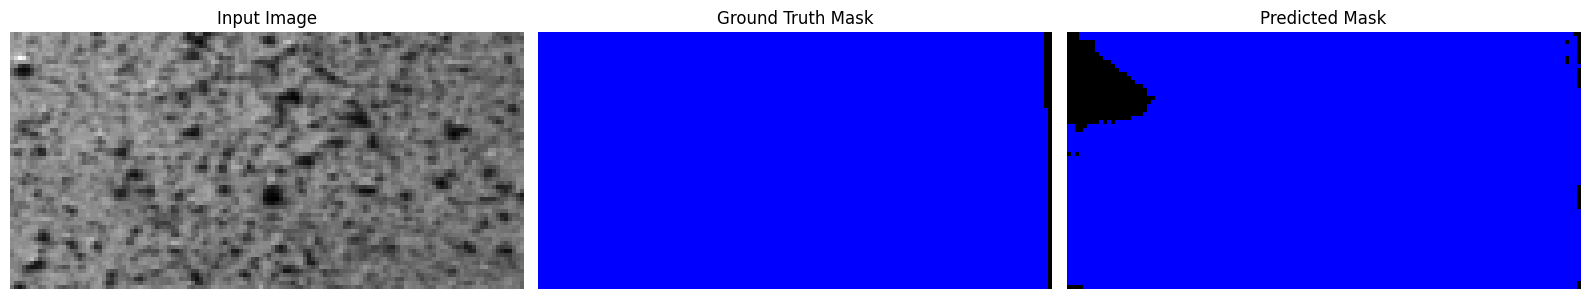

126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.9404 - loss: 0.1597 - mean_iou: 0.5638 - val_accuracy: 0.5868 - val_loss: 1.6051 - val_mean_iou: 0.3219
Epoch 22/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9459 - loss: 0.1453 - mean_iou: 0.5674 - val_accuracy: 0.5957 - val_loss: 1.7029 - val_mean_iou: 0.3254
Epoch 23/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9457 - loss: 0.1410 - mean_iou: 0.5680 - val_accuracy: 0.5533 - val_loss: 2.1594 - val_mean_iou: 0.2534
Epoch 24/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9504 - loss: 0.1308 - mean_iou: 0.5726 - val_accuracy: 0.5930 - val_loss: 1.9492 - val_mean_iou: 0.3092
Epoch 25/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9488 - loss: 0.1339 - mean_iou: 0.5748 - val_accuracy: 0.5601 - val_loss: 2.0361 - val_mean_iou: 0.2638
Epoch 26/250
125/126 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9503 - loss: 0.1336 - mean_iou: 0.5854

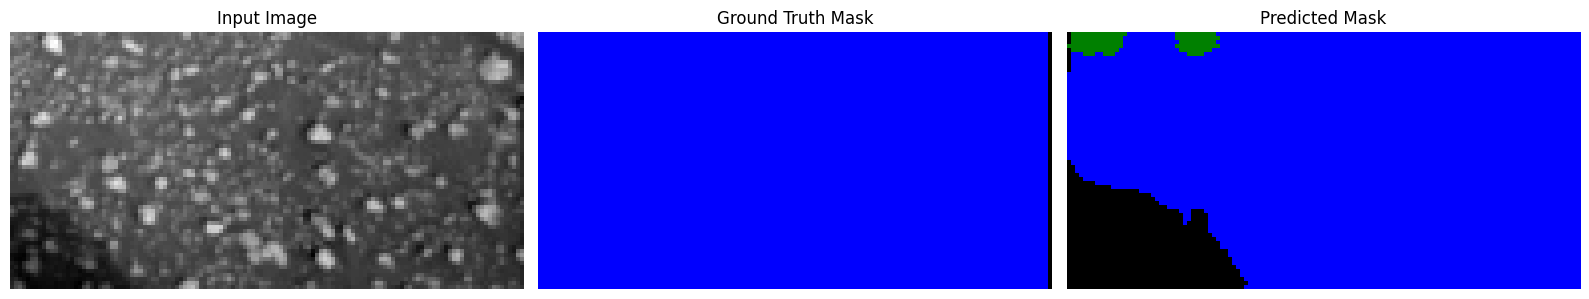

126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - accuracy: 0.9503 - loss: 0.1336 - mean_iou: 0.5854 - val_accuracy: 0.5992 - val_loss: 1.6267 - val_mean_iou: 0.3185
Epoch 27/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9576 - loss: 0.1095 - mean_iou: 0.5990 - val_accuracy: 0.5737 - val_loss: 1.9338 - val_mean_iou: 0.2846
Epoch 28/250
126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9587 - loss: 0.1052 - mean_iou: 0.6160 - val_accuracy: 0.6029 - val_loss: 1.7989 - val_mean_iou: 0.3344


In [113]:
history = model.fit(
    train_dataset,
    epochs=epoch,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    verbose=1
).history



In [114]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation Accuracy: {final_val_accuracy}%')

final_val_loss = round(max(history['val_loss']), 2)
print(f'Final validation Loss: {final_val_loss}%')


# Definisci il percorso di salvataggio nella directory di lavoro
model.save("/kaggle/working/model_.keras")

# Delete the model to free up resources
del model

Final validation Mean Intersection Over Union: 35.72%
Final validation Accuracy: 60.31%
Final validation Loss: 3.37%


# Save Model

In [115]:
model_filename = "model_.keras"
X_test = training_data["test_set"]
model = tfk.models.load_model("/kaggle/working/model_.keras")

preds = model.predict(X_test/255)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
Predictions shape: (10022, 64, 128)


In [116]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [117]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

In [118]:
indices = np.where(np.any(y_train == 4, axis=(1, 2)))[0]
print(len(indices))


41
